In [3]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
from sklearn.metrics import r2_score

In [4]:
df= pd.read_csv("data/최종_최종__월별기상관측.csv",encoding="cp949")
df= df.drop(labels="Unnamed: 0", axis=1)
df

,행정구역,지점명,일시,평균기온(°C),최고기온(°C),최저기온(°C),월합강수량(00~24h만)(mm),합계 일사량(MJ/m2)
0,강원도,속초,2000-01,-0.4,9.9,-10.9,90.2,152.990
1,강원도,속초,2000-02,-0.1,9.2,-8.6,8.4,329.070
2,강원도,속초,2000-03,6.9,18.5,-4.2,8.7,448.650
3,강원도,속초,2000-04,11.2,24.1,2.4,23.4,486.355
4,강원도,속초,2000-05,14.3,30.5,6.2,71.0,520.280
...,...,...,...,...,...,...,...,...
23305,경상남도,남해,2021-08,26.1,35.5,20.7,473.2,481.070
23306,경상남도,남해,2021-09,22.2,30.1,16.3,164.6,366.930
23307,경상남도,남해,2021-10,17.2,28.9,4.7,43.6,429.240
23308,경상남도,남해,2021-11,10.7,21.7,1.4,53.5,323.960


In [5]:
output_raw= pd.read_csv('data/배추_생산량.csv')
output_raw= output_raw.set_index('시도별')

In [6]:
grouped= df.groupby(['행정구역', '일시']).mean()

In [7]:
grouped

평균기온(°C)   최고기온(°C)   최저기온(°C)  월합강수량(00~24h만)(mm)  \
행정구역 일시                                                             
강원도  2000-01  -2.681818   8.690909 -14.745455           58.272727   
     2000-02  -2.872727   7.827273 -14.318182            6.509091   
     2000-03   4.790909  19.000000  -7.936364           13.790909   
     2000-04  10.154545  23.518182  -1.872727           37.354545   
     2000-05  15.618182  31.500000   4.181818           75.181818   
...                 ...        ...        ...                 ...   
충청북도 2021-08  24.160000  34.240000  17.360000          241.860000   
     2021-09  20.680000  29.100000  12.920000          191.580000   
     2021-10  13.760000  29.460000  -1.000000           35.260000   
     2021-11   6.800000  19.880000  -4.900000           47.800000   
     2021-12   0.100000  12.260000 -14.820000            5.080000   

              합계 일사량(MJ/m2)  
행정구역 일시                      
강원도  2000-01     158.358182  
     2000-02     322.926364  
     2000-03     433.992727  
     2000-04     481.298636  
     2000-05     518.235455  
...                     ...  
충청북도 2021-08     445.145000  
     2021-09     426.565000  
     2021-10     407.200000  
     2021-11     243.284000  
     2021-12     253.344000  

[4488 rows x 5 columns]

In [8]:
grouped_fin= grouped
grouped_fin['면적당 생산량']=0

In [11]:
#날씨 -> 면적당 생산량 (기준 동일)
city_list= ['강원도', '경기도', '인천광역시', '서울특별시', '경상북도', '충청북도', '충청남도', '대전광역시','전라남도', '대구광역시', '전라북도', '울산광역시', '경상남도', '광주광역시', '부산광역시', '제주도','세종특별자치시']
detail= ['.1', '.4', '.7', '.10']
spr= ['-03', '-04', '-05']
sum= ['-06', '-07', '-08']
fal= ['-09', '-10', '-11']
win= ['-01', '-02', '-12']
season_list= [spr, sum, fal, win]

for i in range(len(city_list)):
    for l in range(2000, 2022):
        for k in range(len(detail)):
            try:
                val= str(l) + detail[k]
                for n in range(3):
                    dt= str(l) + season_list[k][n]
                    grouped_fin.loc[(city_list[i], dt), '면적당 생산량']= output_raw.loc[city_list[i], val]
            except:
                pass

In [14]:
grouped_fin= grouped_fin[grouped_fin['면적당 생산량'] != 0]
grouped_fin= grouped_fin[grouped_fin['면적당 생산량'] != '-']
grouped_fin= grouped_fin[grouped_fin['면적당 생산량'] != '0']
grouped_fin

평균기온(°C)   최고기온(°C)   최저기온(°C)  월합강수량(00~24h만)(mm)  \
행정구역 일시                                                             
강원도  2000-03   4.790909  19.000000  -7.936364           13.790909   
     2000-04  10.154545  23.518182  -1.872727           37.354545   
     2000-05  15.618182  31.500000   4.181818           75.181818   
     2000-06  20.600000  33.618182   9.190909          132.154545   
     2000-07  24.645455  34.027273  15.972727          156.536364   
...                 ...        ...        ...                 ...   
충청북도 2021-04  12.980000  28.580000   0.260000           62.020000   
     2021-05  16.040000  29.880000   3.220000          158.560000   
     2021-09  20.680000  29.100000  12.920000          191.580000   
     2021-10  13.760000  29.460000  -1.000000           35.260000   
     2021-11   6.800000  19.880000  -4.900000           47.800000   

              합계 일사량(MJ/m2) 면적당 생산량  
행정구역 일시                              
강원도  2000-03     433.992727    4081  
     2000-04     481.298636    4081  
     2000-05     518.235455    4081  
     2000-06     549.963182    3770  
     2000-07     516.617273    3770  
...                     ...     ...  
충청북도 2021-04     585.900000    4491  
     2021-05     561.085000    4491  
     2021-09     426.565000    7321  
     2021-10     407.200000    7321  
     2021-11     243.284000    7321  

[2448 rows x 6 columns]

In [21]:
tt= grouped_fin.reset_index()
train= tt[tt['일시'].str.contains('2020') == False]
test= tt[tt['일시'].str.contains('2020')]
train= train.set_index(['행정구역', '일시'])
test= test.set_index(['행정구역', '일시'])

In [24]:
#방법1: 월 날씨 -> 면적당 생산량
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

feature= train[['평균기온(°C)', '최고기온(°C)', '최저기온(°C)', '월합강수량(00~24h만)(mm)', '합계 일사량(MJ/m2)']]
target= train[['면적당 생산량']]

scaler1= MinMaxScaler()
scaler2= MinMaxScaler()

feature_sc= scaler1.fit_transform(feature)
target_sc= scaler2.fit_transform(target)

X_train, X_val, y_train, y_val= train_test_split(feature_sc, target_sc, test_size=0.2)

In [25]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(1860, 5) (1860, 1)
(465, 5) (465, 1)


In [26]:
X_train= X_train.reshape(1860, -1, 5)
X_val= X_val.reshape(465, -1, 5)

In [27]:
model_1 = Sequential()
model_1.add(LSTM(units=20, activation='relu', input_shape=(1, 5)))
model_1.add(Dense(units=1))
model_1.compile(optimizer='adam', loss='mean_squared_error')

In [28]:
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
model_1.fit(X_train, y_train, epochs=70, batch_size=30, callbacks=[early_stop])

Epoch 1/70
62/62 [==============================] - 1s 1ms/step - loss: 0.1526
Epoch 2/70
62/62 [==============================] - 0s 1ms/step - loss: 0.0713
Epoch 3/70
62/62 [==============================] - 0s 1ms/step - loss: 0.0573
Epoch 4/70
62/62 [==============================] - 0s 1ms/step - loss: 0.0539
Epoch 5/70
62/62 [==============================] - 0s 1ms/step - loss: 0.0499A: 0s - loss: 0.051
Epoch 6/70
62/62 [==============================] - 0s 1ms/step - loss: 0.0432
Epoch 7/70
62/62 [==============================] - 0s 1ms/step - loss: 0.0352A: 0s - loss: 0.036
Epoch 8/70
62/62 [==============================] - 0s 1ms/step - loss: 0.0287
Epoch 9/70
62/62 [==============================] - 0s 2ms/step - loss: 0.0249
Epoch 10/70
62/62 [==============================] - 0s 1ms/step - loss: 0.0235
Epoch 11/70
62/62 [==============================] - 0s 1ms/step - loss: 0.0226
Epoch 12/70
62/62 [==============================] - 0s 1ms/step - loss: 0.0222
Epoch 13/70

In [29]:
pred_y = model_1.predict(X_val)

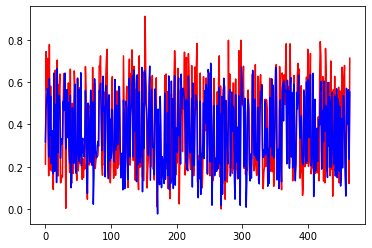

In [30]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(y_val, color='red')
plt.plot(pred_y, color='blue')
plt.show()

In [31]:
test_score= r2_score(y_val, pred_y)
print(test_score)

0.6328794889741998


In [33]:
tt= grouped_fin.reset_index()
train= tt[tt['일시'].str.contains('2020') == False]
test= tt[tt['일시'].str.contains('2020')]
train= train.set_index(['행정구역', '일시'])
test= test.set_index(['행정구역', '일시'])

In [34]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

feature= train[['평균기온(°C)', '최고기온(°C)', '최저기온(°C)', '월합강수량(00~24h만)(mm)', '합계 일사량(MJ/m2)']]
target= train[['면적당 생산량']]

scaler1= MinMaxScaler()
scaler2= MinMaxScaler()

feature_sc= scaler1.fit_transform(feature)
target_sc= scaler2.fit_transform(target)

In [36]:
window_size = 3

data_X = []
data_y = []
for i in range(len(target_sc) - window_size):
    _X = feature_sc[i : i + window_size] # 다음 날 종가(i+windows_size)는 포함되지 않음
    _y = target_sc[i + window_size]     # 다음 날 종가
    data_X.append(_X)
    data_y.append(_y)
print(_X, "->", _y)

[[0.58468062 0.69316479 0.46261145 0.1867449  0.68746243]
 [0.75262849 0.664956   0.73168219 0.22563438 0.47744393]
 [0.5021545  0.67797544 0.34555181 0.04152766 0.44721045]] -> [0.39515091]


In [37]:
train_size = int(len(data_y) * 0.7)
train_X = np.array(data_X[0 : train_size])
train_y = np.array(data_y[0 : train_size])

test_size = len(data_y) - train_size
test_X = np.array(data_X[train_size : len(data_X)])
test_y = np.array(data_y[train_size : len(data_y)])

print('훈련 데이터의 크기 :', train_X.shape, train_y.shape)
print('테스트 데이터의 크기 :', test_X.shape, test_y.shape)

훈련 데이터의 크기 : (1625, 3, 5) (1625, 1)
테스트 데이터의 크기 : (697, 3, 5) (697, 1)


In [38]:
model_2 = Sequential()
model_2.add(LSTM(units=20, activation='relu', input_shape=(3, 5)))
model_2.add(Dense(units=1))
model_2.compile(optimizer='adam', loss='mean_squared_error')

In [39]:
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
model_2.fit(train_X, train_y, epochs=70, batch_size=30, callbacks=[early_stop])

Epoch 1/70
55/55 [==============================] - 3s 2ms/step - loss: 0.0974
Epoch 2/70
55/55 [==============================] - 0s 2ms/step - loss: 0.0363
Epoch 3/70
55/55 [==============================] - 0s 3ms/step - loss: 0.0354
Epoch 4/70
55/55 [==============================] - 0s 2ms/step - loss: 0.0347
Epoch 5/70
55/55 [==============================] - 0s 2ms/step - loss: 0.0335
Epoch 6/70
55/55 [==============================] - 0s 2ms/step - loss: 0.0330
Epoch 7/70
55/55 [==============================] - 0s 2ms/step - loss: 0.0321
Epoch 8/70
55/55 [==============================] - 0s 2ms/step - loss: 0.0312
Epoch 9/70
55/55 [==============================] - 0s 2ms/step - loss: 0.0308
Epoch 10/70
55/55 [==============================] - 0s 2ms/step - loss: 0.0301
Epoch 11/70
55/55 [==============================] - 0s 2ms/step - loss: 0.0296
Epoch 12/70
55/55 [==============================] - 0s 2ms/step - loss: 0.0292
Epoch 13/70
55/55 [==============================

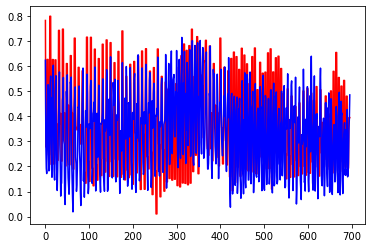

In [40]:
pred_y = model_2.predict(test_X)

plt.figure()
plt.plot(test_y, color='red')
plt.plot(pred_y, color='blue')
plt.show()

In [41]:
test_score= r2_score(test_y, pred_y)
print(test_score)

0.425730699026857


In [42]:
feature= test[['평균기온(°C)', '최고기온(°C)', '최저기온(°C)', '월합강수량(00~24h만)(mm)', '합계 일사량(MJ/m2)']]
target= test[['면적당 생산량']]

feature_sc= scaler1.fit_transform(feature)
target_sc= scaler2.fit_transform(target)

In [43]:
window_size = 3

data_X = []
data_y = []
for i in range(len(target_sc) - window_size):
    _X = feature_sc[i : i + window_size] # 다음 날 종가(i+windows_size)는 포함되지 않음
    _y = target_sc[i + window_size]     # 다음 날 종가
    data_X.append(_X)
    data_y.append(_y)

In [44]:
test_X_1 = np.array(data_X[train_size : len(data_X)])
test_y_1 = np.array(data_y[train_size : len(data_y)])